In [0]:
def missing_values_table(df):
	mis_val = df.isnull().sum()
	mis_val_percent = 100 * df.isnull().sum() / len(df)
	mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
	mis_val_table_ren_columns = mis_val_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'})
	mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values('% of Total Values', ascending=False).round(2)
	print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
	return mis_val_table_ren_columns

def removeConstantVariables(data,colsToExclude):
    colsRemoved = list()
    for col in data:
      if col not in colsToExclude and data[col].nunique() == 1:
        colsRemoved.append(col)
    return colsRemoved
  
def correlation(dataset, threshold):
    col_corr = {} # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr[colname] = corr_matrix.iloc[i, j]
                if colname in dataset.columns:
                  pass
#                    del dataset[colname] # deleting the column from the dataset
    for key, val in col_corr.items():
        print(key, "=>", val)
      
def binning(col, cut_points, labels=None):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  #create list by adding min and max to cut_points
  break_points = [minval] + cut_points + [maxval]

#   print(break_points)
  #if no labels provided, use default labels 0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)

  #Binning using cut function of pandas
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

def plotConfusionMatrix(cm):
  plt.clf()
  plt.imshow(cm,cmap=plt.cm.prism)
  classNames = ['0','1']
  plt.title('Confusion Matrix')
  plt.grid(False)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames)
  plt.yticks(tick_marks, classNames)
  
  s = [['TN','FP'], ['FN', 'TP']]
  for i in range(2):
     for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),ha='center',va='center')
  plt.show()

In [0]:
# Imports

import  pandas as pd
import os
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgbm
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
import seaborn as sns
print("Imported All Imports")

Imported All Imports


In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [0]:
pd.set_option('display.max_columns', 500)

In [0]:
#os.chdir("godrive/app/predictDamage")

#!ls -l /home/
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131322 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&acces

In [0]:
#  !ls -l drive/app/predictDamage
# !cd drive/app/predictDamage
# !pwd

import os
os.chdir("drive/Analytics Vidya/HR Analytics - AV")
os.listdir()
# !cd drive/'LG- HackerEarth'/
# !ls -lrth 

# !pwd
# !cd drive/app

['sample.csv',
 'test.csv',
 'train.csv',
 'xgb_1',
 'xgb_2',
 'lgb',
 'xgb_1.csv',
 'xgb_2.csv',
 'lgb.csv',
 'HR Analytics']

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")

In [0]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [0]:
train.shape

(54808, 14)

In [0]:
train.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [0]:
train.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [0]:
missing_values_table(train)

Your selected dataframe has 14 columns.
 There are 2 columns that have missing values.


,Missing Values,% of Total Values
previous_year_rating,4124,7.52
education,2409,4.40


In [0]:
train['previous_year_rating'].value_counts()

3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: previous_year_rating, dtype: int64

In [0]:
train['education'].value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

In [0]:
train.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

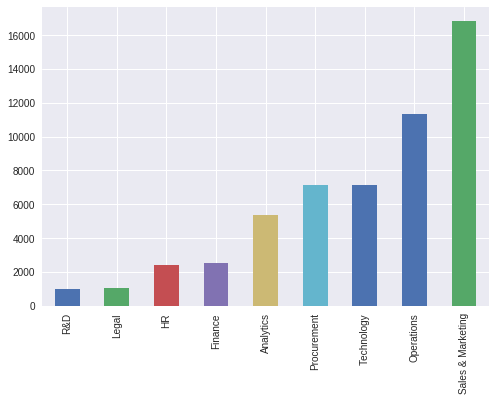

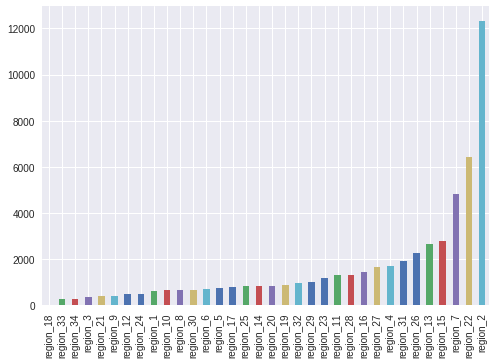

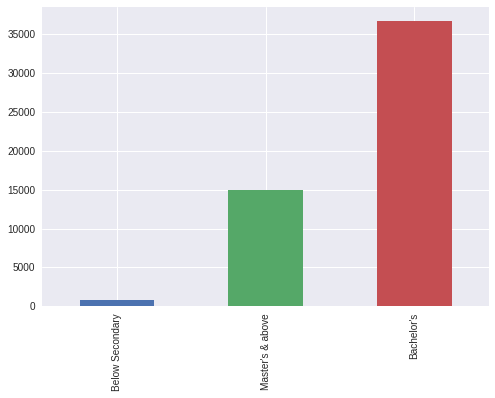

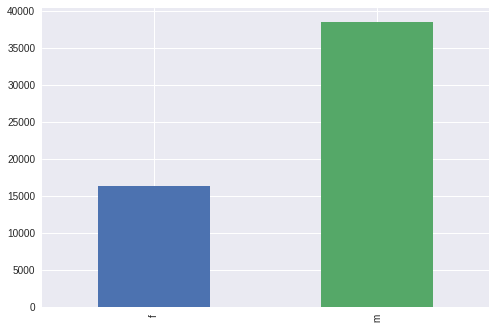

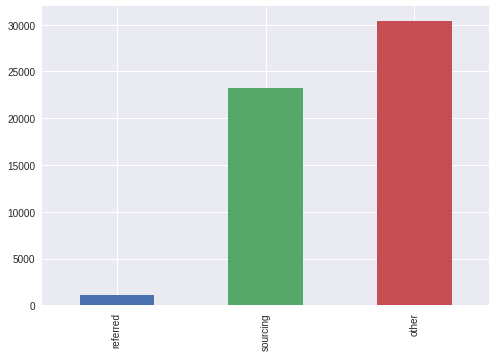

In [0]:
# Plotting all categorical variables
for i in train.columns:
  if train[i].dtype == 'object':
    train[i].value_counts().sort_values().plot('bar')
    plt.show()

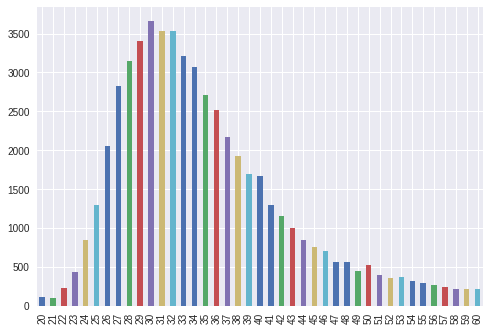

In [0]:
train['age'].value_counts().sort_index().plot('bar')

In [0]:
# # Converting age variale into categorical variable using binning
# cut_points = [30,40,50]
# labels = ["youth","middle","old","very_old"]
# train["age_cat"] = binning(train["age"], cut_points, labels)
# # print(pd.value_counts(train["age_cat"], sort=False))

In [0]:
# train['age_cat'].value_counts().sort_index().plot('bar')

In [0]:
# train[(train['education'].isin(["Bachelor's"])) & (train['age'] < 21)]

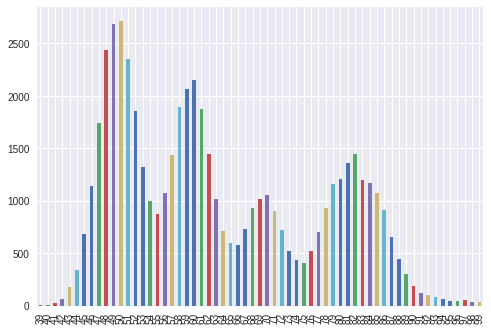

In [0]:
train['avg_training_score'].value_counts().sort_index().plot('bar')

In [0]:
# # Missing values - Previous Year rating is imputed with 0 which indicates freshers
# values={"previous_year_rating":0,"education":"Others"}
# train.fillna(value=values,inplace=True)

In [0]:
missing_values_table(train)

Your selected dataframe has 14 columns.
 There are 2 columns that have missing values.


,Missing Values,% of Total Values
previous_year_rating,4124,7.52
education,2409,4.40


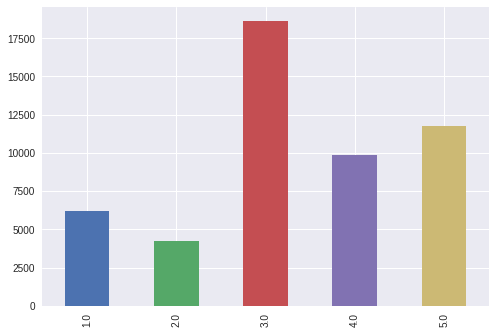

In [0]:
train['previous_year_rating'].value_counts().sort_index().plot('bar')

In [0]:
# def preProcessData(df):
# #   Imputing Missing Values
#   values={"previous_year_rating":train['previous_year_rating'].mode(),"education":"Others"}
#   df.fillna(value=values,inplace=True)
  
# # 
#   return df

In [0]:
train.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [0]:
# finalData_test['Geo_Field'] = le.fit_transform(finalData_test['Geo_Field'])

In [0]:
def preProcessData(df):
#   Missing Values Treatment
  values={"previous_year_rating":0,"education":"Others"}
  df.fillna(value=values,inplace=True)
#   Binning oF Age Variable
  # Converting age variale into categorical variable using binning
  cut_points = [30,40,50]
  labels = ["youth","middle","old","very_old"]
  df["age_cat"] = binning(df["age"], cut_points, labels)
#   Label Encoding of Categorical Variable
  for i in df.columns:
    if df[i].dtype == 'object' or pd.api.types.is_categorical_dtype(df[i]):
      df[i] = le.fit_transform(df[i])
  print("Pre-Processing completed")
  return df

In [0]:
train = preProcessData(train)

Pre-Processing completed


In [0]:
train.dtypes

employee_id               int64
department                int64
region                    int64
education                 int64
gender                    int64
recruitment_channel       int64
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
age_cat                   int64
dtype: object

In [0]:
def addNewFeatures(df):
  df['total_training_score'] = df['no_of_trainings'] * df['avg_training_score']
  df['score_per_year'] = df['total_training_score']/df['length_of_service']
  df['work_fraction'] = df['length_of_service'] / df['age']
  df['start_year'] = df['age'] - df['length_of_service']
  return df

In [0]:
train = addNewFeatures(train)

In [0]:
train.dtypes

employee_id               int64
department                int64
region                    int64
education                 int64
gender                    int64
recruitment_channel       int64
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
age_cat                   int64
total_training_score      int64
score_per_year          float64
work_fraction           float64
start_year                int64
dtype: object

In [0]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,age_cat,total_training_score,score_per_year,work_fraction,start_year
0,65438,7,31,2,0,2,1,35,5.0,8,1,0,49,0,0,49,6.125000,0.228571,27
1,65141,4,14,0,1,0,1,30,5.0,4,0,0,60,0,3,60,15.000000,0.133333,26
2,7513,7,10,0,1,2,1,34,3.0,7,0,0,50,0,0,50,7.142857,0.205882,27
3,2542,7,15,0,1,0,2,39,1.0,10,0,0,50,0,0,100,10.000000,0.256410,29
4,48945,8,18,0,1,0,1,45,3.0,2,0,0,73,0,1,73,36.500000,0.044444,43


In [0]:
test = preProcessData(test)

Pre-Processing completed


In [0]:
test = addNewFeatures(test)

In [0]:
X = train.drop(['employee_id','age','is_promoted'],axis=1)

In [0]:
Y = np.array(train['is_promoted'].tolist())

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Model 1 - XGB Classifier

In [0]:
xgb_model_1 = xgbm.XGBClassifier()
print(xgb_model_1)
# Cross validation scores
f1_scores = cross_val_score(xgb_model_1, X_train, Y_train, cv=5, scoring='f1')
print(f1_scores," Mean = ",np.mean(f1_scores))

# Training the models
xgb_model_1.fit(X_train,Y_train)

# Scoring on test set
# test_data,score_xgb = score_on_test_set(xgb_model,"test.csv","submission_xgb.csv")

Y_test_preds = xgb_model_1.predict(X_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
[0.38166047 0.40148699 0.42041312 0.41990291 0.38154613]  Mean =  0.4010019259467672


In [0]:
cm = confusion_matrix(Y_test,Y_test_preds)

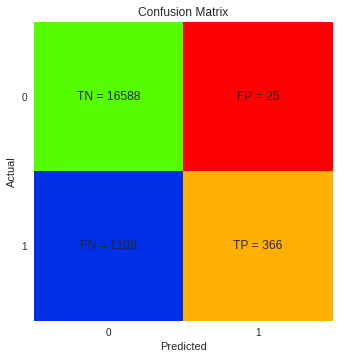

In [0]:
plotConfusionMatrix(cm)

In [0]:
params = {
     'learning_rate': [0.001],
     'n_estimators': [1000],
     'max_depth':[10],
     'reg_alpha':[0.4]
    }

# Initializing the XGBoost Regressor
xgb_model = xgbm.XGBClassifier()

# Gridsearch initializaation
gsearch = GridSearchCV(xgb_model, params,
                    verbose=True,
                    cv=5,
                    n_jobs=2)

gsearch.fit(X_train, Y_train)

#Printing the best chosen params
print(gsearch.best_params_)

params = {'objective':'binary:logistic', 'booster':'gbtree'}

# Updating the parameter as per grid search
params.update(gsearch.best_params_)

# Initializing the XGBoost Regressor
xgb_model = xgbm.XGBClassifier(**params)
print(xgb_model)

# Cross validation scores
f1_scores_1 = cross_val_score(xgb_model, X_train, Y_train, cv=5, scoring='f1',n_jobs=2)
print(f1_scores_1," Mean = ",np.mean(f1_scores_1))

# Fitting model on tuned parameters
xgb_model.fit(X_train, Y_train)
Y_test_preds_1 = xgb_model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.9min finished


{'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 1000, 'reg_alpha': 0.4}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.001, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
[0.4774044  0.41105769 0.47981546 0.46332945 0.40240964]  Mean =  0.4468033285105122


In [0]:
cm_1 = confusion_matrix(Y_test,Y_test_preds_1)

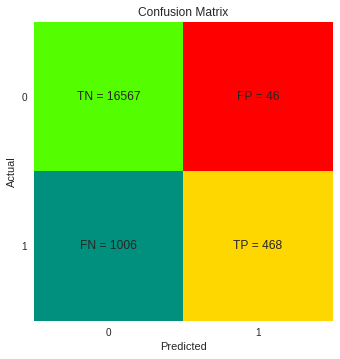

In [0]:
plotConfusionMatrix(cm_1)

In [0]:
# Initializing the LightGBM model
lgbm_model = lgb.LGBMClassifier(objective='binary')

# Cross validation score 
f1_scores_2 = cross_val_score(lgbm_model, X_train, Y_train, cv=5, scoring='f1',n_jobs=3)
print(f1_scores," Mean = ",np.mean(f1_scores_2))

# Fitting LightGBM model
lgbm_model.fit(X_train, Y_train)
#                , eval_set=[(X_test, Y_test)], eval_metric='auc', early_stopping_rounds=150)

Y_test_preds_2 = lgbm_model.predict(X_test,num_iteration=lgbm_model.best_iteration_)


[0.38166047 0.40148699 0.42041312 0.41990291 0.38154613]  Mean =  0.48899405934599666


In [0]:
cm_2 = confusion_matrix(Y_test,Y_test_preds_2)

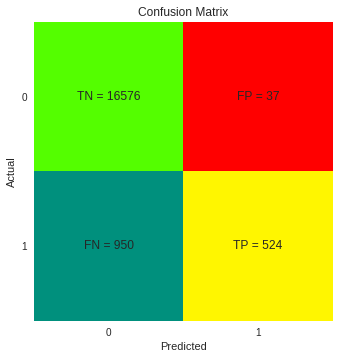

In [0]:
plotConfusionMatrix(cm_2)

In [0]:
test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,age_cat,total_training_score,score_per_year,work_fraction,start_year
0,8724,8,18,0,1,2,1,24,0.0,1,1,0,77,3,77,77.000000,0.041667,23
1,74430,2,28,0,0,0,1,31,3.0,5,0,0,51,0,51,10.200000,0.161290,26
2,72255,7,4,0,1,0,1,31,1.0,4,0,0,47,0,47,11.750000,0.129032,27
3,38562,5,11,0,0,0,3,31,2.0,9,0,0,65,0,195,21.666667,0.290323,22
4,64486,1,21,0,1,2,1,30,4.0,7,0,0,61,3,61,8.714286,0.233333,23


In [0]:
testSet_X = test.drop(['employee_id','age'],axis=1)

In [0]:
testSetPreds_X_1 = xgb_model_1.predict(testSet_X)

In [0]:
testSetPreds_X_2 = xgb_model.predict(testSet_X)

In [0]:
testSetPreds_X_3 = lgbm_model.predict(testSet_X)

In [0]:
submission_df_1 = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':testSetPreds_X_1})
submission_df_1.to_csv("xgb_1.csv", index=False)

In [0]:
submission_df_2 = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':testSetPreds_X_2})
submission_df_2.to_csv("xgb_2.csv", index=False)

In [0]:
submission_df_3 = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':testSetPreds_X_3})
submission_df_3.to_csv("lgb.csv", index=False)

In [0]:
from google.colab import files
files.download("xgb_1.csv")
files.download("xgb_2.csv")
files.download("lgb.csv")

In [0]:
#Logistic Regression
from sklearn import linear_model
lr = linear_model.LogisticRegression(C=1000,solver='liblinear')
lr.fit(X_train,Y_train)
prediction_lr = lr.predict(X_test)

print('####Accuracy:', accuracy_score(Y_test, prediction_lr))
print('####Precision:', precision_score(Y_test, prediction_lr))
print('####Recall:', recall_score(Y_test, prediction_lr))
print('####F1 Score:',f1_score(Y_test, prediction_lr, average='binary'))

testSetPreds_lr = lr.predict(testSet_X)

submission_lr = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':testSetPreds_lr})
submission_lr.to_csv("lr.csv", index=False)

# prediction = lr.predict(finalData_test)
# pd.DataFrame({'Customer_ID': test_data['Customer_ID'], 'Store_Code': test_data['Store_Code'], 'Prediction' : prediction},columns=['Customer_ID', 'Store_Code','Prediction']).to_csv('lr.csv', index=False)
# from google.colab import files
# files.download('lr_1.csv')

####Accuracy: 0.919887211809587
####Precision: 0.5706214689265536
####Recall: 0.06852103120759837
####F1 Score: 0.12235009085402784


In [0]:
#oob_score = TRUE, n_jobs = -1,random_state =50,max_features = "auto", min_samples_leaf
#Random Forest
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators=1000,oob_score = True, n_jobs = -1,max_features = "auto", min_samples_leaf=10)
rf.fit(X_train,Y_train)
prediction_rf = rf.predict(X_test)

print('####Accuracy:', accuracy_score(Y_test, prediction_rf))
print('####Precision:', precision_score(Y_test, prediction_rf))
print('####Recall:', recall_score(Y_test, prediction_rf))
print('####F1 Score:',f1_score(Y_test, prediction_rf, average='binary'))

testSetPreds_rf = lr.predict(testSet_X)

submission_rf = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':testSetPreds_rf})
submission_rf.to_csv("rf.csv", index=False) 

####Accuracy: 0.9346491955548184
####Precision: 0.9219653179190751
####Recall: 0.21641791044776118
####F1 Score: 0.3505494505494506


In [0]:
#Predctng usng KNN
from sklearn import neighbors
KN = neighbors.KNeighborsClassifier()
KN.fit(X_train,Y_train)
predict_KN = KN.predict(X_test)

print('####Accuracy:', accuracy_score(Y_test, predict_KN))
print('####Precision:', precision_score(Y_test, predict_KN))
print('####Recall:', recall_score(Y_test, predict_KN))
print('####F1 Score:',f1_score(Y_test, predict_KN, average='binary'))


testSetPreds_knn = lr.predict(testSet_X)

submission_knn = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':testSetPreds_knn})
submission_knn.to_csv("knn.csv", index=False) 

####Accuracy: 0.9249737380438989
####Precision: 0.693069306930693
####Recall: 0.14246947082767977
####F1 Score: 0.23635340461451881


In [0]:
from google.colab import files
files.download("lr.csv")
files.download("rf.csv")
files.download("knn.csv")

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind='regular')
X_SMOTE, y_SMOTE = sm.fit_sample(X, Y)
X_SMOTE = pd.DataFrame(X_SMOTE)
X_SMOTE.columns = X_train.columns

In [0]:
X_SMOTE.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,age_cat,total_training_score,score_per_year,work_fraction,start_year
0,7.0,31.0,2.0,0.0,2.0,1.0,5.0,8.0,1.0,0.0,49.0,0.0,49.0,6.125000,0.228571,27.0
1,4.0,14.0,0.0,1.0,0.0,1.0,5.0,4.0,0.0,0.0,60.0,3.0,60.0,15.000000,0.133333,26.0
2,7.0,10.0,0.0,1.0,2.0,1.0,3.0,7.0,0.0,0.0,50.0,0.0,50.0,7.142857,0.205882,27.0
3,7.0,15.0,0.0,1.0,0.0,2.0,1.0,10.0,0.0,0.0,50.0,0.0,100.0,10.000000,0.256410,29.0
4,8.0,18.0,0.0,1.0,0.0,1.0,3.0,2.0,0.0,0.0,73.0,1.0,73.0,36.500000,0.044444,43.0


In [0]:
X_train_SM, X_test_SM, Y_train_SM, Y_test_SM = train_test_split(X_SMOTE, y_SMOTE, test_size=0.33, random_state=42)

In [0]:
# Initializing the LightGBM model
lgbm_model_smote = lgb.LGBMClassifier(objective='binary')

# Cross validation score 
f1_scores_2 = cross_val_score(lgbm_model_smote, X_train_SM, Y_train_SM, cv=5, scoring='f1',n_jobs=3)
print(f1_scores," Mean = ",np.mean(f1_scores_2))

# Fitting LightGBM model
lgbm_model_smote.fit(X_train_SM, Y_train_SM)
#                , eval_set=[(X_test, Y_test)], eval_metric='auc', early_stopping_rounds=150)

Y_test_preds_SMOTE = lgbm_model_smote.predict(X_test_SM,num_iteration=lgbm_model_smote.best_iteration_)


[0.38166047 0.40148699 0.42041312 0.41990291 0.38154613]  Mean =  0.9612476058847754


In [0]:
cm_smote = confusion_matrix(Y_test_SM,Y_test_preds_SMOTE)

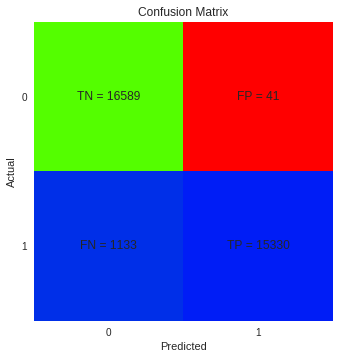

In [0]:
plotConfusionMatrix(cm_smote)

In [0]:
testSetPreds_smote = lgbm_model_smote.predict(testSet_X)

In [0]:
submission_lgbm_smote_1 = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':testSetPreds_smote})
submission_lgbm_smote_1.to_csv("submission_lgbm_smote_1.csv", index=False)

In [0]:
from google.colab import files
files.download("submission_lgbm_smote_1.csv")

In [0]:
# # # Detecting Outliers

# Q1 = finalData['Revenue'].quantile(0.25)
# Q3 = finalData['Revenue'].quantile(0.75)
# IQR = Q3 - Q1
# # print(IQR)
# # print(finalData[(finalData['Revenue'] < (Q1 - 1.5 * IQR)) | (finalData['Revenue'] > (Q3 + 1.5 * IQR)) == True])

# finalData['Revenue'] = finalData['Revenue'][~((finalData['Revenue'] < (Q1 - 1.5 * IQR)) |(finalData['Revenue'] > (Q3 + 1.5 * IQR)))]

In [0]:
# # https://stackoverflow.com/questions/38420847/apply-standardscaler-on-a-partial-part-of-a-data-set
# from sklearn import preprocessing
# scaled_features = finalData.copy()
# col_names = ['Revenue', 'Discount','','']
# features = scaled_features[col_names]
# scaler = StandardScaler().fit(features.values)
# features = scaler.transform(features.values)
# scaled_features[col_names] = features